# Analysis on 2D Heisenberg model

In [1]:
import multiprocessing
import sys
import os
from pathlib import Path
from time import time
from socket import gethostname

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

# set plot customisation
plt.rc('font',**{'family':'serif',
             'serif': 'cmr10',
             'size': 12})
plt.rc('mathtext',**{'fontset':'cm'})
plt.rc('axes', unicode_minus=False, linewidth=1.2, xmargin=0,
           prop_cycle=cycler('color', ['#008fd5',
          '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c']))

from heisenberg_2d import initialize, metropolis, energy, magnetization

In [2]:
# Settings
snaps = []
n_temp = 500

N = 10
H = 1
steps = 4000
temp = np.linspace(0.3, 10.5, n_temp)

data_path = './results'

## Routine

In [3]:
## small sanity check on input parameters
if N<2 or steps<1 or temp[0]<0:
    print("Invalid command line parameters")

## parameters to calculate running average (notice that these are averages per spin)
n1 = 1.0/(steps*N*N)
n2 = 1.0/(steps*steps*N*N)
   
def start(T: float):
    """ Run the routine for temperature T and return E, M, C, X"""
# for ii, T in enumerate(temp):
    E1=0
    M1=0
    E2=0
    M2=0
    grid = initialize(N) ## get the initial configuration
    beta = 1.0/T ## k_B = 1  


    ## first we equilibrate the system 
    ## (assumption is that snapshots are wanted here)
    for t in range(steps):
        if t in snaps:
            plot_system(grid, t, T, H)

        metropolis(grid, beta, H)

    ## then we start to actually collect data, if we aren't just plotting snapshots
    if len(snaps)==0:
        for t in range(steps):
            metropolis(grid, beta, H)
            tE = energy(grid, H)
            tM = magnetization(grid)

            E1 += tE
            E2 += tE*tE
            M1 += tM
            M2 += tM*tM

        E = n1*E1
        M = n1*M1
        C = beta*beta*(n1*E2 - n2*E1*E1)
        X = beta*(n1*M2 - n2*M1*M1)
        
    return E, M, C, X

In [4]:
# Run the routine in parallel (NB: might not work on windows)
t0 = time()

# Run without parallel processing if on Windows
if os.name == 'nt':
    results = list(map(start, temp))
    E, M, C, X = np.array(results).T
else:
    print(f'Using {os.cpu_count()} threads on {gethostname()}')
    with multiprocessing.Pool() as pool:
        results = pool.map(start, temp)
        E, M, C, X = np.array(results).T
    
print(f'wall time: {time() - t0} s')

Using 80 threads on brute
wall time: 40.782971143722534 s


### Save results

In [5]:
# mkdir in case
if not os.path.exists(data_path):
    os.makedirs(data_path)

# gather results in a table just in case
df = pd.DataFrame(results, columns=['E', 'M', 'C', 'X'])
df['temp'] = temp
for name, var in zip(['n_temp', 'N', 'steps', 'H'], [n_temp, N, steps, H]):
    df[name] = var
    
# save the table
df.to_csv(f'{data_path}/data_{n_temp}_{N}_{steps}_{H}.csv', sep=',', header=True, index=False)
display(df)

,E,M,C,X,temp,n_temp,N,steps,H
0,-0.655472,0.946848,0.152797,0.075779,0.300000,500,10,4000,1
1,-0.683170,0.872202,0.000124,0.000085,0.320441,500,10,4000,1
2,-0.716430,0.892451,0.006423,0.001564,0.340882,500,10,4000,1
3,-0.723906,1.031776,0.040330,0.007557,0.361323,500,10,4000,1
4,-0.811343,1.061312,0.126485,0.042574,0.381764,500,10,4000,1
...,...,...,...,...,...,...,...,...,...
495,-0.069785,0.121062,0.002911,0.115776,10.418236,500,10,4000,1
496,-0.069449,0.119082,0.002805,0.119746,10.438677,500,10,4000,1
497,-0.066858,0.115050,0.002799,0.112718,10.459118,500,10,4000,1
498,-0.066847,0.117332,0.002821,0.112040,10.479559,500,10,4000,1


## Gather all results

In [10]:
data_path = './results'

dfs = [pd.read_csv(f) for f in Path.cwd().rglob(f'{data_path}/*.csv')]
df = pd.concat(dfs, axis=0, join='inner').sort_index()

In [11]:
df

,E,M,C,X,temp,n_temp,N,steps,H
0,-0.655472,0.946848,0.152797,0.075779,0.300000,500,10,4000,1
1,-0.683170,0.872202,0.000124,0.000085,0.320441,500,10,4000,1
2,-0.716430,0.892451,0.006423,0.001564,0.340882,500,10,4000,1
3,-0.723906,1.031776,0.040330,0.007557,0.361323,500,10,4000,1
4,-0.811343,1.061312,0.126485,0.042574,0.381764,500,10,4000,1
...,...,...,...,...,...,...,...,...,...
495,-0.069785,0.121062,0.002911,0.115776,10.418236,500,10,4000,1
496,-0.069449,0.119082,0.002805,0.119746,10.438677,500,10,4000,1
497,-0.066858,0.115050,0.002799,0.112718,10.459118,500,10,4000,1
498,-0.066847,0.117332,0.002821,0.112040,10.479559,500,10,4000,1


### Plotting

Example of plotting all simulation data with a specific size $N$

In [12]:
df[df['N'] == 10]

,E,M,C,X,temp,n_temp,N,steps,H
0,-0.655472,0.946848,0.152797,0.075779,0.300000,500,10,4000,1
1,-0.683170,0.872202,0.000124,0.000085,0.320441,500,10,4000,1
2,-0.716430,0.892451,0.006423,0.001564,0.340882,500,10,4000,1
3,-0.723906,1.031776,0.040330,0.007557,0.361323,500,10,4000,1
4,-0.811343,1.061312,0.126485,0.042574,0.381764,500,10,4000,1
...,...,...,...,...,...,...,...,...,...
495,-0.069785,0.121062,0.002911,0.115776,10.418236,500,10,4000,1
496,-0.069449,0.119082,0.002805,0.119746,10.438677,500,10,4000,1
497,-0.066858,0.115050,0.002799,0.112718,10.459118,500,10,4000,1
498,-0.066847,0.117332,0.002821,0.112040,10.479559,500,10,4000,1


In [18]:
E, M, C, X, temp, *_ = df[df['N'] == 10].values.T

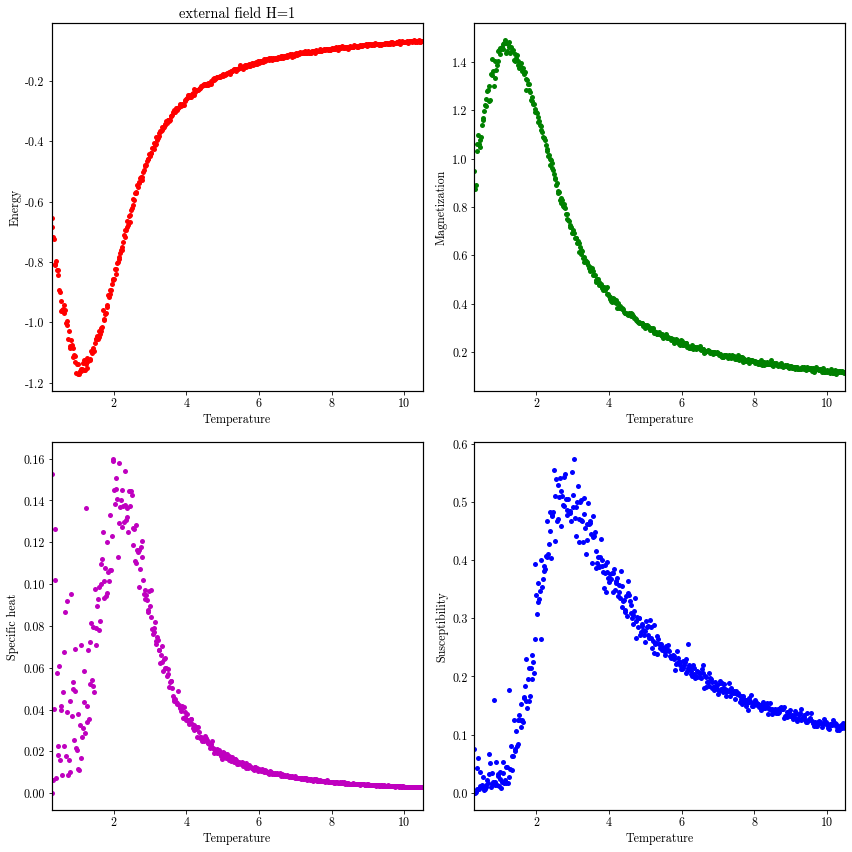

In [19]:
## then we plot a figure with energy, magnetization, specific heat and susceptibility
if len(snaps)==0:
    plt.figure(figsize=(12,12))

    plt.subplot(2,2,1)
    plt.title('external field H={}'.format(H))
    plt.plot(temp, E, 'ro', markeredgecolor='none', markersize=5)
    plt.xlabel('Temperature')
    plt.ylabel('Energy')

    plt.subplot(2,2,2)
    plt.plot(temp, M, 'go', markeredgecolor='none', markersize=5)
    plt.xlabel('Temperature')
    plt.ylabel('Magnetization')

    plt.subplot(2,2,3)
    plt.plot(temp, C, 'mo', markeredgecolor='none', markersize=5)
    plt.xlabel('Temperature')
    plt.ylabel('Specific heat')

    plt.subplot(2,2,4)
    plt.plot(temp, X, 'bo', markeredgecolor='none', markersize=5)
    plt.xlabel('Temperature')
    plt.ylabel('Susceptibility')


    plt.tight_layout()
    ## uncomment if you want to save the data
    #np.savetxt("ising_2d_{}_{}_{}.dat".format(N,steps,H), np.array([temp, E, M , C,X]).transpose())

plt.show()

### TODO
gather all data and compare with $N$